In [14]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/email_classification.csv')

In [5]:
df.head()

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


In [6]:
df.isna().sum()

email    0
label    0
dtype: int64

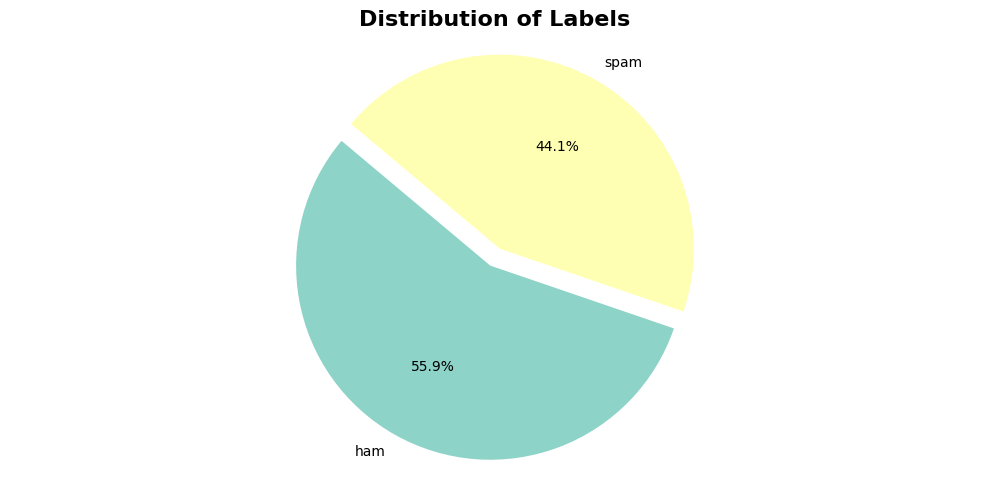

In [7]:
labels = df['label'].value_counts().index
sizes = df['label'].value_counts().values
colors =  plt.cm.Set3.colors

plt.figure(figsize=(10, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0.1, 0))
plt.title('Distribution of Labels', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

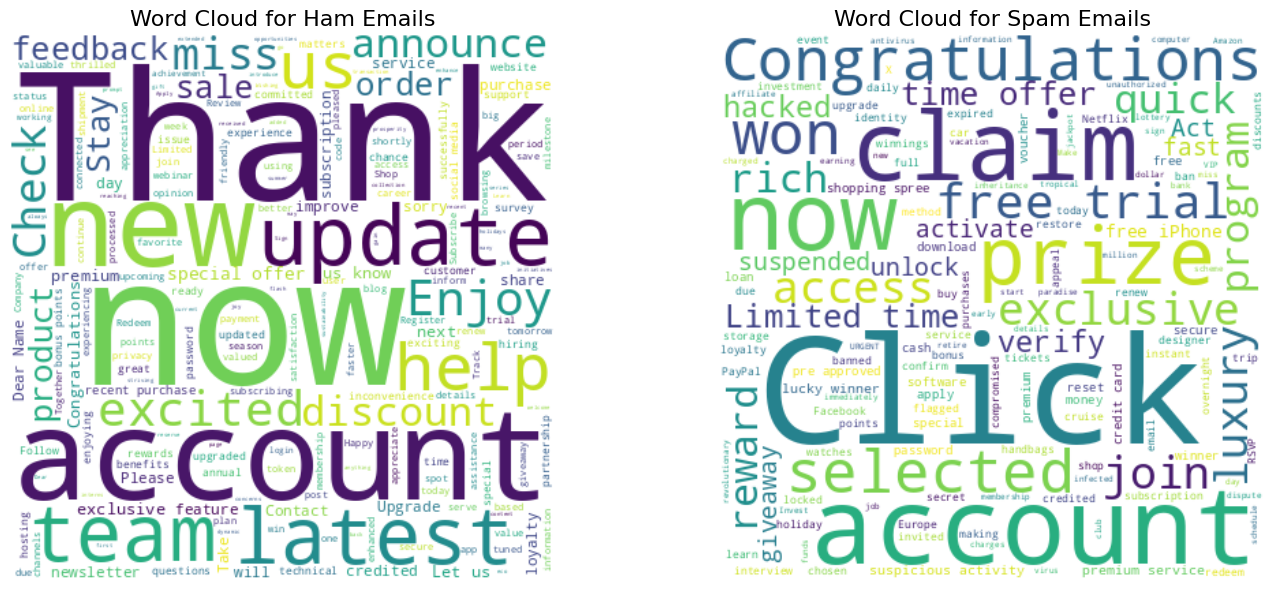

In [8]:
ham_text_data = df[df['label'] == 'ham']['email'].values
spam_text_data = df[df['label'] == 'spam']['email'].values
texts = {'ham': ham_text_data, 'spam': spam_text_data}

plt.figure(figsize=(15, 6))

for i, (label, data) in enumerate(texts.items(), start=1):
    all_text = ' '.join(data)
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(all_text)

    plt.subplot(1, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label.capitalize()} Emails', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

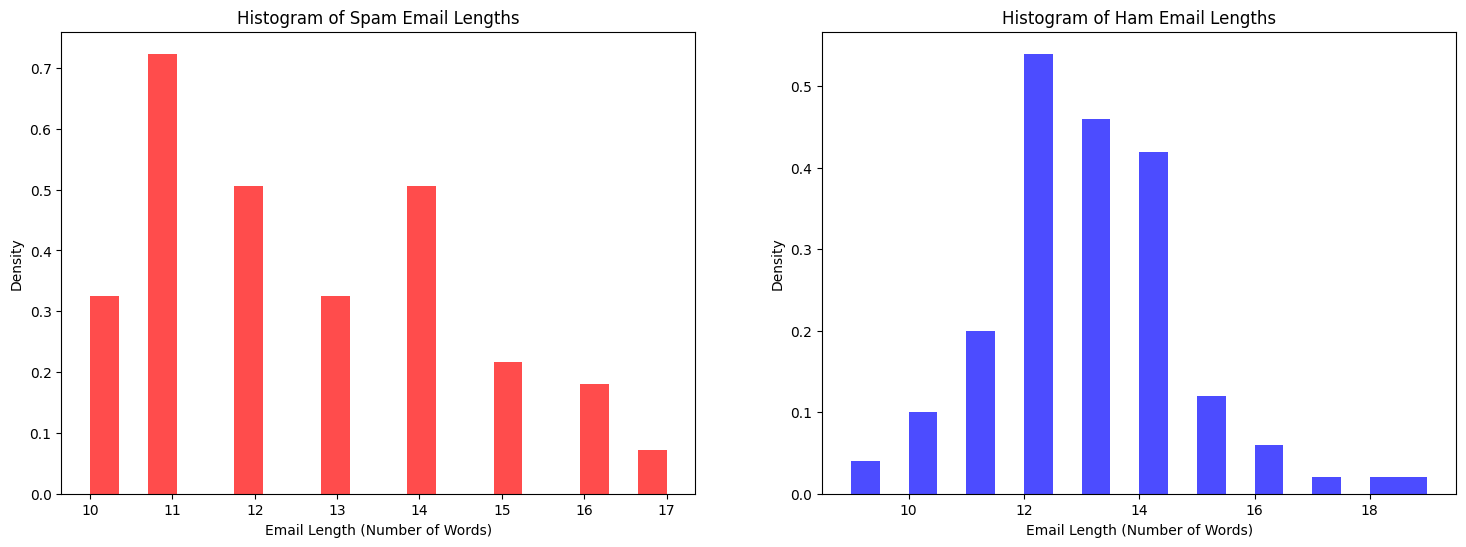

In [9]:
spam_lengths = [len(email.split()) for email in df[df['label'] == 'spam']['email']]
ham_lengths = [len(email.split()) for email in df[df['label'] == 'ham']['email']]

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

# Plot histogram for spam emails
axes[0].hist(spam_lengths, bins=20, color='red', alpha=0.7, density=True)
axes[0].set_title('Histogram of Spam Email Lengths')
axes[0].set_xlabel('Email Length (Number of Words)')
axes[0].set_ylabel('Density')

# Plot histogram for ham emails
axes[1].hist(ham_lengths, bins=20, color='blue', alpha=0.7, density=True)
axes[1].set_title('Histogram of Ham Email Lengths')
axes[1].set_xlabel('Email Length (Number of Words)')
axes[1].set_ylabel('Density')

plt.show()

In [10]:
# create preprocessor

def preprocessor(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = word_tokenize(text.lower())
    text = [PorterStemmer().stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

# initialize labelEncoder & countVectorizer

encoder = LabelEncoder()
vectorizer = CountVectorizer()

In [15]:
# clean all the emails

df['email'] = df['email'].apply(preprocessor)

# encode the labels

df['label'] = encoder.fit_transform(df['label'])

# display the modified dataset

df.head()

,email,label
0,upgrad premium plan exclus access premium cont...,0
1,happi holiday team wish joy prosper season,0
2,hire check career opportun join dynam team,0
3,amazon account lock click verifi account inform,1
4,opinion matter take survey help us enhanc experi,0


In [16]:
# extract features and target

X = vectorizer.fit_transform(df['email']).toarray()
y = df.iloc[:, -1].values

# split the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# print the shape of train/test features and labels

print(f'\nShape of Training Features (X_train) --> {X_train.shape} and \
Training Labels (y_train) --> {y_train.shape}')

print(f'\nShape of Testing Features (X_train) --> {X_test.shape} and \
Testing Labels (y_test) --> {y_test.shape}')


Shape of Training Features (X_train) --> (143, 381) and Training Labels (y_train) --> (143,)

Shape of Testing Features (X_train) --> (36, 381) and Testing Labels (y_test) --> (36,)


In [18]:
from xgboost import XGBClassifier

model = XGBClassifier()

In [19]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:

y_pred_test = model.predict(X_test)


In [22]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

<Axes: >

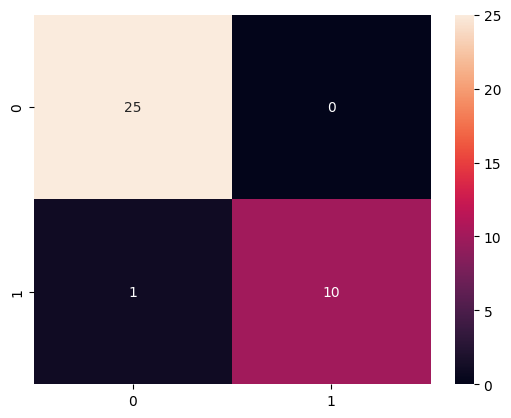

In [24]:
import seaborn as sns

sns.heatmap(conf_matrix, annot = True)

In [26]:
from sklearn.metrics import classification_report

print('Classificaion Report: \n', classification_report(y_test, y_pred_test))

Classificaion Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.91      0.95        11

    accuracy                           0.97        36
   macro avg       0.98      0.95      0.97        36
weighted avg       0.97      0.97      0.97        36

